<a href="https://colab.research.google.com/github/Inconsequential-24/CNN_PCG/blob/main/CNN_PCG_MODEL1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Automatic diagnosis of multiple cardiac diseases from PCG signals using convolutional neural network**

**Please download the dataset and set the path. The dataset can be downloaded from the given link:** *https://drive.google.com/drive/folders/1N1DvcnvJwUqh-IyHtrG7JsuCxmJPOhiU?usp=sharing*

**MODEL 1**

<ipython-input-17-96f450e0ef87>:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data_augmented = np.array(data_augmented)


Epoch 1/50
75/75 [==============================] - 2s 7ms/step - loss: 1.6729 - accuracy: 0.2262 - val_loss: 1.5484 - val_accuracy: 0.2650
Epoch 2/50
75/75 [==============================] - 0s 4ms/step - loss: 1.4628 - accuracy: 0.4192 - val_loss: 1.3466 - val_accuracy: 0.4833
Epoch 3/50
75/75 [==============================] - 0s 5ms/step - loss: 1.3052 - accuracy: 0.5013 - val_loss: 1.1973 - val_accuracy: 0.5650
Epoch 4/50
75/75 [==============================] - 0s 4ms/step - loss: 1.2342 - accuracy: 0.5342 - val_loss: 1.1344 - val_accuracy: 0.5967
Epoch 5/50
75/75 [==============================] - 0s 4ms/step - loss: 1.1462 - accuracy: 0.5800 - val_loss: 1.1436 - val_accuracy: 0.5617
Epoch 6/50
75/75 [==============================] - 0s 4ms/step - loss: 1.1007 - accuracy: 0.6008 - val_loss: 1.0405 - val_accuracy: 0.6400
Epoch 7/50
75/75 [==============================] - 0s 5ms/step - loss: 1.0313 - accuracy: 0.6125 - val_loss: 0.9846 - val_accuracy: 0.6550
Epoch 8/50
75/75 [==

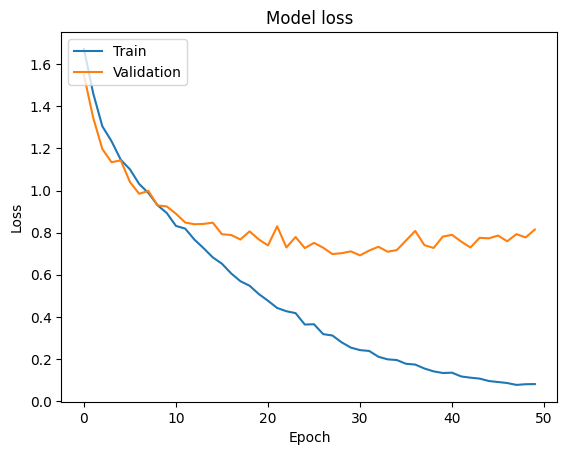

CNN Model Diagram


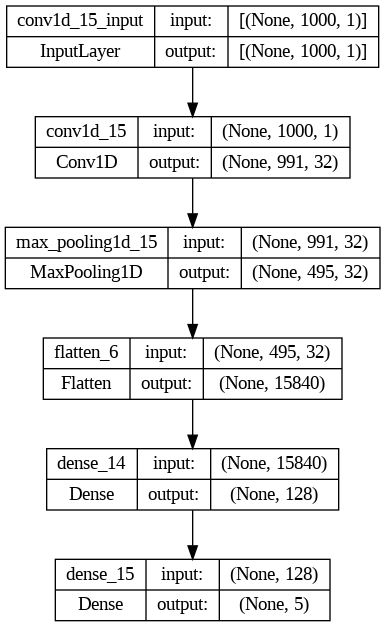

In [ ]:
import os
import numpy as np
from scipy.io import wavfile
import librosa
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
from keras.utils.vis_utils import plot_model

# Set the path to the dataset folder
dataset_path = '/content/drive/MyDrive/dataset'

# Define the classes
classes = ['normal', 'aortic_stenosis', 'mitral_stenosis', 'mitral_valve_prolapse', 'pericardial_murmurs']

# Data preprocessing
pcg_data = []
labels = []
for i, class_name in enumerate(classes):
    class_path = os.path.join(dataset_path, class_name)
    for filename in os.listdir(class_path):
        if filename.endswith('.wav'):
            file_path = os.path.join(class_path, filename)
            _, signal = wavfile.read(file_path)
            pcg_data.append(signal)
            labels.append(i)

# Normalize each individual signal in pcg_data
scaler = StandardScaler()
normalized_data = []

for signal in pcg_data:
    normalized_signal = scaler.fit_transform(signal.reshape(-1, 1)).flatten()
    normalized_data.append(normalized_signal)

# Convert the normalized_data list to a NumPy array
normalized_data = np.array(normalized_data, dtype=object)
labels = np.array(labels)

# Outlier Removal
filtered_data = []
threshold = 0.1  # Adjust the threshold value as needed

for pcg_signal in normalized_data:
    energy = np.sum(pcg_signal ** 2)
    if energy > threshold:
        filtered_data.append(pcg_signal)

# Scaling the filtered data
scaler = MinMaxScaler()
scaled_data = []

for pcg_signal in filtered_data:
    scaled_signal = scaler.fit_transform(pcg_signal.reshape(-1, 1)).flatten()
    scaled_data.append(scaled_signal)

# Convert the scaled_data list to a NumPy array
scaled_data = np.array(scaled_data, dtype=object)

# Data augmentation
data_augmented = []
labels_augmented = []
augmentation_factor = 3  # Number of augmented samples to generate for each original sample

for i in range(scaled_data.shape[0]):
    x = scaled_data[i]
    y = labels[i]

    # Perform data augmentation
    for _ in range(augmentation_factor):
        # Time Shift
        time_shift = np.random.randint(-50, 50)  # Specify the time shift range
        x_shifted = np.roll(x, time_shift)

        augmented_signal = x_shifted

        # Add the augmented sample and its label to the augmented data list
        data_augmented.append(augmented_signal)
        labels_augmented.append(y)

# Convert the augmented data to numpy arrays
data_augmented = np.array(data_augmented)
labels_augmented = np.array(labels_augmented)

# Pad or truncate the sequences to a fixed length
max_length = 1000  # Adjust the maximum length as needed
data_augmented = pad_sequences(data_augmented, maxlen=max_length, dtype='float32', padding='post', truncating='post')

# Shuffle the augmented data
data_augmented, labels_augmented = shuffle(data_augmented, labels_augmented, random_state=42)

# Reshape the data for CNN input
image_height = 1
image_width = max_length
num_channels = 1

# Define training parameters
epochs = 50
batch_size = 32

# Data splitting
x_train, x_test, y_train, y_test = train_test_split(data_augmented, labels_augmented, test_size=0.2, random_state=42)

# Prepare the CNN model architecture
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=10, activation='relu', input_shape=(image_width, num_channels)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(units=128, activation='relu'))
model.add(Dense(units=len(classes), activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history= model.fit(x_train, to_categorical(y_train), epochs=epochs, batch_size=batch_size, validation_data=(x_test, to_categorical(y_test)))

# Evaluate the model
test_loss, test_accuracy = model.evaluate(x_test, to_categorical(y_test))
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

print ('CNN Model Diagram')
# Display the model diagram
plot_model(model, to_file='model_diagram.png', show_shapes=True, show_layer_names=True)


**MODEL 2**

Epoch 1/50


<ipython-input-18-14c65ebd345b>:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data_augmented = np.array(data_augmented)


75/75 [==============================] - 2s 9ms/step - loss: 1.6285 - accuracy: 0.2237 - val_loss: 1.5816 - val_accuracy: 0.2300
Epoch 2/50
75/75 [==============================] - 0s 6ms/step - loss: 1.5118 - accuracy: 0.3767 - val_loss: 1.4459 - val_accuracy: 0.4100
Epoch 3/50
75/75 [==============================] - 1s 8ms/step - loss: 1.3423 - accuracy: 0.4717 - val_loss: 1.2488 - val_accuracy: 0.5117
Epoch 4/50
75/75 [==============================] - 0s 6ms/step - loss: 1.2492 - accuracy: 0.5258 - val_loss: 1.1935 - val_accuracy: 0.4967
Epoch 5/50
75/75 [==============================] - 1s 7ms/step - loss: 1.1911 - accuracy: 0.5350 - val_loss: 1.1224 - val_accuracy: 0.6000
Epoch 6/50
75/75 [==============================] - 0s 5ms/step - loss: 1.1499 - accuracy: 0.5387 - val_loss: 1.0609 - val_accuracy: 0.6217
Epoch 7/50
75/75 [==============================] - 0s 5ms/step - loss: 1.0779 - accuracy: 0.6042 - val_loss: 1.0637 - val_accuracy: 0.6017
Epoch 8/50
75/75 [=============

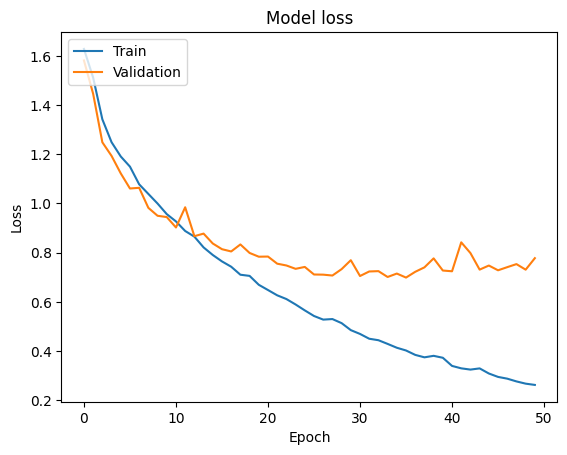

CNN Model Diagram


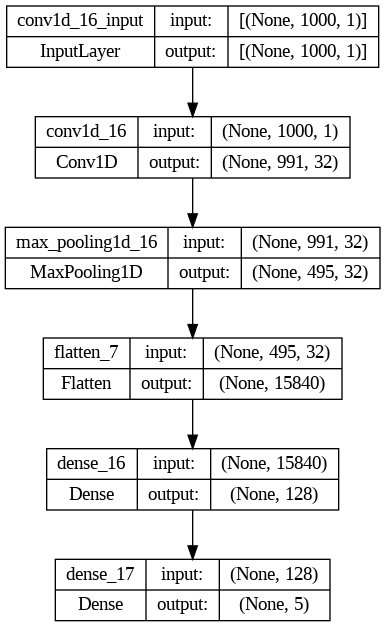

In [ ]:
import os
import numpy as np
from scipy.io import wavfile
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
from keras.utils.vis_utils import plot_model


# Set the path to the dataset folder
dataset_path = '/content/drive/MyDrive/dataset'

# Define the classes
classes = ['normal', 'aortic_stenosis', 'mitral_stenosis', 'mitral_valve_prolapse', 'pericardial_murmurs']

# Data preprocessing
pcg_data = []
labels = []
for i, class_name in enumerate(classes):
    class_path = os.path.join(dataset_path, class_name)
    for filename in os.listdir(class_path):
        if filename.endswith('.wav'):
            file_path = os.path.join(class_path, filename)
            _, signal = wavfile.read(file_path)
            pcg_data.append(signal)
            labels.append(i)

# Normalize each individual signal in pcg_data
scaler = StandardScaler()
normalized_data = []

for signal in pcg_data:
    normalized_signal = scaler.fit_transform(signal.reshape(-1, 1)).flatten()
    normalized_data.append(normalized_signal)

# Convert the normalized_data list to a NumPy array
normalized_data = np.array(normalized_data, dtype=object)
labels = np.array(labels)

# Outlier Removal
filtered_data = []
threshold = 0.1  # Adjust the threshold value as needed

for pcg_signal in normalized_data:
    energy = np.sum(pcg_signal ** 2)
    if energy > threshold:
        filtered_data.append(pcg_signal)

# Scaling the filtered data
scaler = MinMaxScaler()
scaled_data = []

for pcg_signal in filtered_data:
    scaled_signal = scaler.fit_transform(pcg_signal.reshape(-1, 1)).flatten()
    scaled_data.append(scaled_signal)

# Convert the scaled_data list to a NumPy array
scaled_data = np.array(scaled_data, dtype=object)

# Data augmentation
data_augmented = []
labels_augmented = []
augmentation_factor = 3  # Number of augmented samples to generate for each original sample

for i in range(scaled_data.shape[0]):
    x = scaled_data[i]
    y = labels[i]

    # Perform data augmentation
    for _ in range(augmentation_factor):
        # Time Shift
        time_shift = np.random.randint(-50, 50)  # Specify the time shift range
        x_shifted = np.roll(x, time_shift)

        augmented_signal = x_shifted

        # Add the augmented sample and its label to the augmented data list
        data_augmented.append(augmented_signal)
        labels_augmented.append(y)

# Convert the augmented data to numpy arrays
data_augmented = np.array(data_augmented)
labels_augmented = np.array(labels_augmented)

# Pad or truncate the sequences to a fixed length
max_length = 1000  # Adjust the maximum length as needed
data_augmented = pad_sequences(data_augmented, maxlen=max_length, dtype='float32', padding='post', truncating='post')

# Shuffle the augmented data
data_augmented, labels_augmented = shuffle(data_augmented, labels_augmented, random_state=42)

# Reshape the data for CNN input
image_height = 1
image_width = max_length
num_channels = 1

# Define training parameters
epochs = 50
batch_size = 32

# Data splitting
x_train, x_test, y_train, y_test = train_test_split(data_augmented, labels_augmented, test_size=0.2, random_state=42)

# Prepare the CNN model architecture
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=10, activation='relu', input_shape=(image_width, num_channels)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(units=128, activation='relu'))
model.add(Dense(units=len(classes), activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(x_train, to_categorical(y_train), epochs=epochs, batch_size=batch_size, validation_data=(x_test, to_categorical(y_test)))

# Evaluate the model
test_loss, test_accuracy = model.evaluate(x_test, to_categorical(y_test))
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Plot the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

print ('CNN Model Diagram')
# Display the model diagram
plot_model(model, to_file='model_diagram.png', show_shapes=True, show_layer_names=True)


**MODEL 3**

Epoch 1/50


<ipython-input-19-f12c2109d8ab>:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data_augmented = np.array(data_augmented)


75/75 [==============================] - 2s 9ms/step - loss: 1.5185 - accuracy: 0.3150 - val_loss: 1.2930 - val_accuracy: 0.5667
Epoch 2/50
75/75 [==============================] - 0s 6ms/step - loss: 1.2136 - accuracy: 0.5271 - val_loss: 0.9965 - val_accuracy: 0.6350
Epoch 3/50
75/75 [==============================] - 0s 6ms/step - loss: 0.9843 - accuracy: 0.6121 - val_loss: 0.8604 - val_accuracy: 0.6683
Epoch 4/50
75/75 [==============================] - 0s 6ms/step - loss: 0.8145 - accuracy: 0.6842 - val_loss: 0.7581 - val_accuracy: 0.7350
Epoch 5/50
75/75 [==============================] - 0s 6ms/step - loss: 0.6882 - accuracy: 0.7350 - val_loss: 0.7538 - val_accuracy: 0.7267
Epoch 6/50
75/75 [==============================] - 0s 6ms/step - loss: 0.6009 - accuracy: 0.7713 - val_loss: 0.6826 - val_accuracy: 0.7550
Epoch 7/50
75/75 [==============================] - 0s 6ms/step - loss: 0.4956 - accuracy: 0.8225 - val_loss: 0.6743 - val_accuracy: 0.7783
Epoch 8/50
75/75 [=============

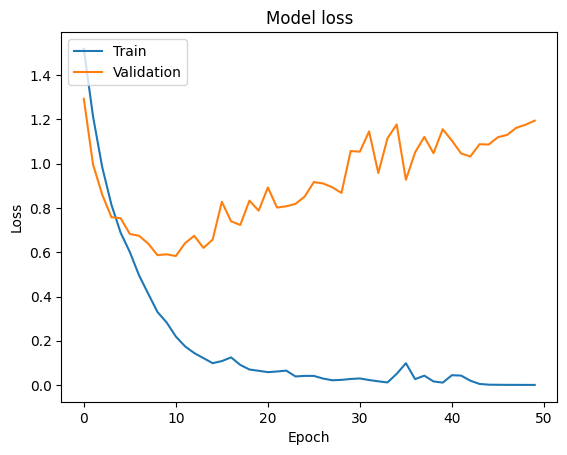

CNN Model Diagram


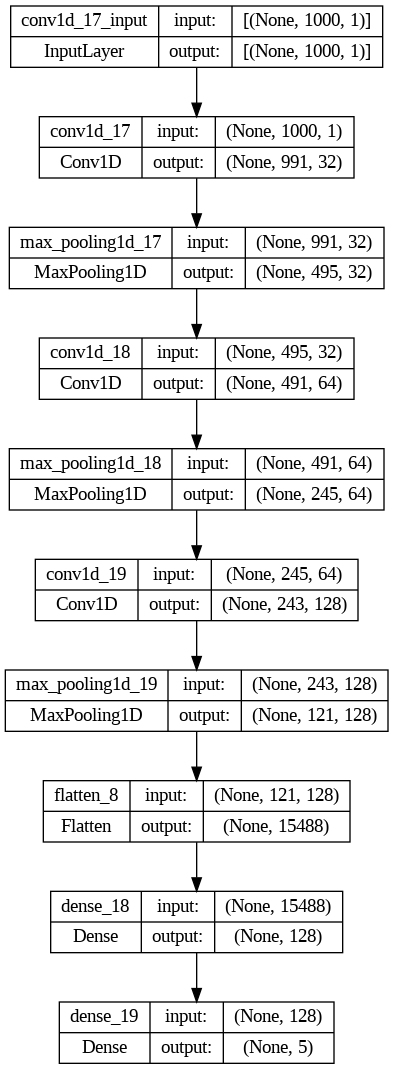

In [ ]:
import os
import numpy as np
from scipy.io import wavfile
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
from keras.utils.vis_utils import plot_model


# Set the path to the dataset folder
dataset_path = '/content/drive/MyDrive/dataset'

# Define the classes
classes = ['normal', 'aortic_stenosis', 'mitral_stenosis', 'mitral_valve_prolapse', 'pericardial_murmurs']

# Data preprocessing
pcg_data = []
labels = []
for i, class_name in enumerate(classes):
    class_path = os.path.join(dataset_path, class_name)
    for filename in os.listdir(class_path):
        if filename.endswith('.wav'):
            file_path = os.path.join(class_path, filename)
            _, signal = wavfile.read(file_path)
            pcg_data.append(signal)
            labels.append(i)

# Normalize each individual signal in pcg_data
scaler = MinMaxScaler()
normalized_data = []

for signal in pcg_data:
    normalized_signal = scaler.fit_transform(signal.reshape(-1, 1)).flatten()
    normalized_data.append(normalized_signal)

# Convert the normalized_data list to a NumPy array
normalized_data = np.array(normalized_data, dtype=object)
labels = np.array(labels)

# Outlier Removal
filtered_data = []
threshold = 0.1  # Adjust the threshold value as needed

for pcg_signal in normalized_data:
    energy = np.sum(pcg_signal ** 2)
    if energy > threshold:
        filtered_data.append(pcg_signal)

# Scaling the filtered data
scaler = MinMaxScaler()
scaled_data = []

for pcg_signal in filtered_data:
    scaled_signal = scaler.fit_transform(pcg_signal.reshape(-1, 1)).flatten()
    scaled_data.append(scaled_signal)

# Convert the scaled_data list to a NumPy array
scaled_data = np.array(scaled_data, dtype=object)

# Data augmentation
data_augmented = []
labels_augmented = []
augmentation_factor = 3  # Number of augmented samples to generate for each original sample

for i in range(scaled_data.shape[0]):
    x = scaled_data[i]
    y = labels[i]

    # Perform data augmentation
    for _ in range(augmentation_factor):
        # Time Shift
        time_shift = np.random.randint(-50, 50)  # Specify the time shift range
        x_shifted = np.roll(x, time_shift)

        augmented_signal = x_shifted

        # Add the augmented sample and its label to the augmented data list
        data_augmented.append(augmented_signal)
        labels_augmented.append(y)

# Convert the augmented data to numpy arrays
data_augmented = np.array(data_augmented)
labels_augmented = np.array(labels_augmented)

# Pad or truncate the sequences to a fixed length
max_length = 1000  # Adjust the maximum length as needed
data_augmented = pad_sequences(data_augmented, maxlen=max_length, dtype='float32', padding='post', truncating='post')

# Shuffle the augmented data
data_augmented, labels_augmented = shuffle(data_augmented, labels_augmented, random_state=42)

# Reshape the data for CNN input
image_height = 1
image_width = max_length
num_channels = 1

# Define training parameters
epochs = 50
batch_size = 32

# Data splitting
x_train, x_test, y_train, y_test = train_test_split(data_augmented, labels_augmented, test_size=0.2, random_state=42)

# Prepare the CNN model architecture
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=10, activation='relu', input_shape=(image_width, num_channels)))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(units=128, activation='relu'))
model.add(Dense(units=len(classes), activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(x_train, to_categorical(y_train), epochs=epochs, batch_size=batch_size, validation_data=(x_test, to_categorical(y_test)))

# Evaluate the model
test_loss, test_accuracy = model.evaluate(x_test, to_categorical(y_test))
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Plot the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

print ('CNN Model Diagram')
# Display the model diagram
plot_model(model, to_file='model_diagram.png', show_shapes=True, show_layer_names=True)


**MODEL 4**

Epoch 1/50


<ipython-input-20-e9b1c15e0e4e>:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data_augmented = np.array(data_augmented)


75/75 [==============================] - 5s 18ms/step - loss: 1.5262 - accuracy: 0.3254 - val_loss: 1.2323 - val_accuracy: 0.5300
Epoch 2/50
75/75 [==============================] - 1s 15ms/step - loss: 1.1615 - accuracy: 0.5342 - val_loss: 0.8970 - val_accuracy: 0.6717
Epoch 3/50
75/75 [==============================] - 1s 15ms/step - loss: 0.8465 - accuracy: 0.6642 - val_loss: 0.7940 - val_accuracy: 0.6983
Epoch 4/50
75/75 [==============================] - 1s 15ms/step - loss: 0.6446 - accuracy: 0.7550 - val_loss: 0.6364 - val_accuracy: 0.7867
Epoch 5/50
75/75 [==============================] - 1s 15ms/step - loss: 0.5021 - accuracy: 0.8117 - val_loss: 0.6414 - val_accuracy: 0.7950
Epoch 6/50
75/75 [==============================] - 1s 14ms/step - loss: 0.3828 - accuracy: 0.8675 - val_loss: 0.5315 - val_accuracy: 0.8333
Epoch 7/50
75/75 [==============================] - 1s 14ms/step - loss: 0.2881 - accuracy: 0.8954 - val_loss: 0.4615 - val_accuracy: 0.8500
Epoch 8/50
75/75 [======

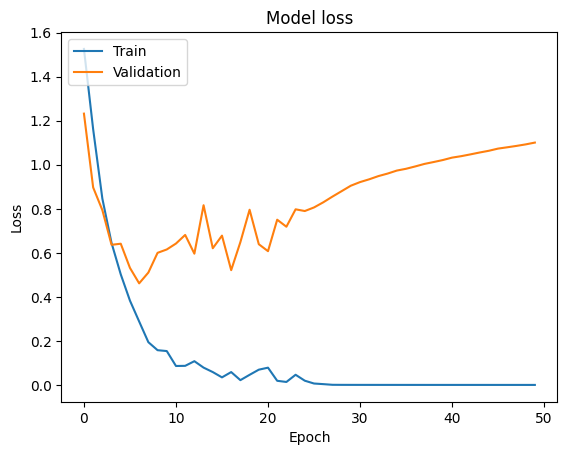

CNN Model Diagram


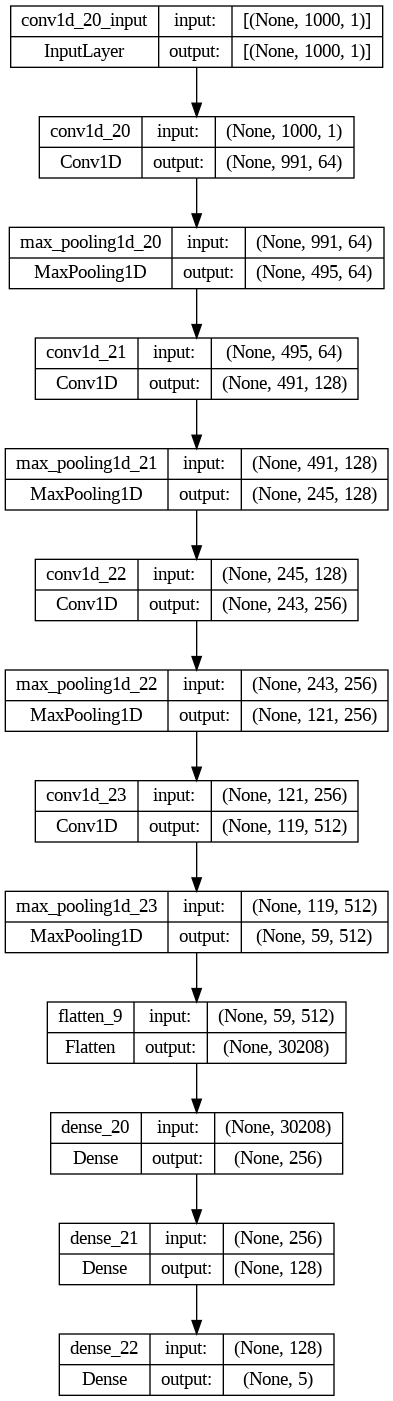

In [ ]:
import os
import numpy as np
from scipy.io import wavfile
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
from keras.utils.vis_utils import plot_model


# Set the path to the dataset folder
dataset_path = '/content/drive/MyDrive/dataset'

# Define the classes
classes = ['normal', 'aortic_stenosis', 'mitral_stenosis', 'mitral_valve_prolapse', 'pericardial_murmurs']

# Data preprocessing
pcg_data = []
labels = []
for i, class_name in enumerate(classes):
    class_path = os.path.join(dataset_path, class_name)
    for filename in os.listdir(class_path):
        if filename.endswith('.wav'):
            file_path = os.path.join(class_path, filename)
            _, signal = wavfile.read(file_path)
            pcg_data.append(signal)
            labels.append(i)

# Normalize each individual signal in pcg_data
scaler = MinMaxScaler()
normalized_data = []

for signal in pcg_data:
    normalized_signal = scaler.fit_transform(signal.reshape(-1, 1)).flatten()
    normalized_data.append(normalized_signal)

# Convert the normalized_data list to a NumPy array
normalized_data = np.array(normalized_data, dtype=object)
labels = np.array(labels)

# Outlier Removal
filtered_data = []
threshold = 0.1  # Adjust the threshold value as needed

for pcg_signal in normalized_data:
    energy = np.sum(pcg_signal ** 2)
    if energy > threshold:
        filtered_data.append(pcg_signal)

# Scaling the filtered data
scaler = MinMaxScaler()
scaled_data = []

for pcg_signal in filtered_data:
    scaled_signal = scaler.fit_transform(pcg_signal.reshape(-1, 1)).flatten()
    scaled_data.append(scaled_signal)

# Convert the scaled_data list to a NumPy array
scaled_data = np.array(scaled_data, dtype=object)

# Data augmentation
data_augmented = []
labels_augmented = []
augmentation_factor = 3  # Number of augmented samples to generate for each original sample

for i in range(scaled_data.shape[0]):
    x = scaled_data[i]
    y = labels[i]

    # Perform data augmentation
    for _ in range(augmentation_factor):
        # Time Shift
        time_shift = np.random.randint(-50, 50)  # Specify the time shift range
        x_shifted = np.roll(x, time_shift)

        augmented_signal = x_shifted

        # Add the augmented sample and its label to the augmented data list
        data_augmented.append(augmented_signal)
        labels_augmented.append(y)

# Convert the augmented data to numpy arrays
data_augmented = np.array(data_augmented)
labels_augmented = np.array(labels_augmented)

# Pad or truncate the sequences to a fixed length
max_length = 1000  # Adjust the maximum length as needed
data_augmented = pad_sequences(data_augmented, maxlen=max_length, dtype='float32', padding='post', truncating='post')

# Shuffle the augmented data
data_augmented, labels_augmented = shuffle(data_augmented, labels_augmented, random_state=42)

# Reshape the data for CNN input
image_height = 1
image_width = max_length
num_channels = 1

# Define training parameters
epochs = 50
batch_size = 32

# Data splitting
x_train, x_test, y_train, y_test = train_test_split(data_augmented, labels_augmented, test_size=0.2, random_state=42)

# Prepare the CNN model architecture
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=10, activation='relu', input_shape=(image_width, num_channels)))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=256, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=512, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(units=256, activation='relu'))
model.add(Dense(units=128, activation='relu'))
model.add(Dense(units=len(classes), activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(x_train, to_categorical(y_train), epochs=epochs, batch_size=batch_size, validation_data=(x_test, to_categorical(y_test)))

# Evaluate the model
test_loss, test_accuracy = model.evaluate(x_test, to_categorical(y_test))
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Plot the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

print ('CNN Model Diagram')
# Display the model diagram
plot_model(model, to_file='model_diagram.png', show_shapes=True, show_layer_names=True)

**MODEL 5**

Epoch 1/50
75/75 [==============================] - 4s 24ms/step - loss: 1.5502 - accuracy: 0.2692 - val_loss: 1.2995 - val_accuracy: 0.4833
Epoch 2/50
75/75 [==============================] - 1s 18ms/step - loss: 1.2688 - accuracy: 0.4608 - val_loss: 1.1209 - val_accuracy: 0.5617
Epoch 3/50
75/75 [==============================] - 1s 18ms/step - loss: 1.1230 - accuracy: 0.5329 - val_loss: 0.9864 - val_accuracy: 0.6333
Epoch 4/50
75/75 [==============================] - 1s 17ms/step - loss: 0.9049 - accuracy: 0.6242 - val_loss: 0.8252 - val_accuracy: 0.6700
Epoch 5/50
75/75 [==============================] - 1s 17ms/step - loss: 0.7348 - accuracy: 0.7142 - val_loss: 0.6547 - val_accuracy: 0.7750
Epoch 6/50
75/75 [==============================] - 1s 17ms/step - loss: 0.5581 - accuracy: 0.7971 - val_loss: 0.6003 - val_accuracy: 0.7817
Epoch 7/50
75/75 [==============================] - 1s 17ms/step - loss: 0.4709 - accuracy: 0.8221 - val_loss: 0.5385 - val_accuracy: 0.8117
Epoch 8/50
75

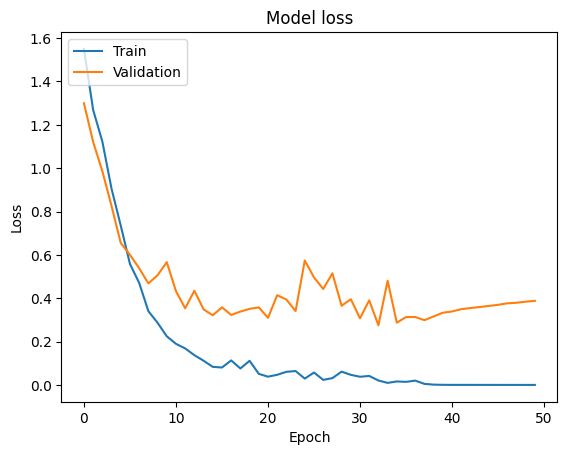

In [ ]:
import os
import numpy as np
from scipy.io import wavfile
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt

# Set the path to the dataset folder
dataset_path = '/content/drive/MyDrive/dataset'

# Define the classes
classes = ['normal', 'aortic_stenosis', 'mitral_stenosis', 'mitral_valve_prolapse', 'pericardial_murmurs']

# Data preprocessing
pcg_data = []
labels = []
for i, class_name in enumerate(classes):
    class_path = os.path.join(dataset_path, class_name)
    for filename in os.listdir(class_path):
        if filename.endswith('.wav'):
            file_path = os.path.join(class_path, filename)
            _, signal = wavfile.read(file_path)
            pcg_data.append(signal)
            labels.append(i)

# Normalize each individual signal in pcg_data
scaler = MinMaxScaler()
normalized_data = []

for signal in pcg_data:
    normalized_signal = scaler.fit_transform(signal.reshape(-1, 1)).flatten()
    normalized_data.append(normalized_signal)

# Convert the normalized_data list to a NumPy array
normalized_data = np.array(normalized_data, dtype=object)
labels = np.array(labels)

# Outlier Removal
filtered_data = []
threshold = 0.1  # Adjust the threshold value as needed

for pcg_signal in normalized_data:
    energy = np.sum(pcg_signal ** 2)
    if energy > threshold:
        filtered_data.append(pcg_signal)

# Scaling the filtered data
scaler = MinMaxScaler()
scaled_data = []

for pcg_signal in filtered_data:
    scaled_signal = scaler.fit_transform(pcg_signal.reshape(-1, 1)).flatten()
    scaled_data.append(scaled_signal)

# Convert the scaled_data list to a NumPy array
scaled_data = np.array(scaled_data, dtype=object)

# Data augmentation
data_augmented = []
labels_augmented = []
augmentation_factor = 3  # Number of augmented samples to generate for each original sample
max_length = 1000  # Adjust the maximum length as needed

for i in range(len(scaled_data)):
    x = scaled_data[i]
    y = labels[i]

    # Perform data augmentation
    for _ in range(augmentation_factor):
        # Time Shift
        time_shift = np.random.randint(-50, 50)  # Specify the time shift range
        x_shifted = np.roll(x, time_shift)

        # Pad the sequence
        x_padded = pad_sequences([x_shifted], maxlen=max_length, dtype='float32', padding='post', truncating='post')[0]

        # Add the augmented sample and its label to the augmented data list
        data_augmented.append(x_padded)
        labels_augmented.append(y)

# Convert the augmented data to numpy arrays
data_augmented = np.array(data_augmented)
labels_augmented = np.array(labels_augmented)

# Shuffle the augmented data
data_augmented, labels_augmented = shuffle(data_augmented, labels_augmented, random_state=42)

# Reshape the data for CNN input
data_augmented = data_augmented.reshape(data_augmented.shape[0], max_length, 1)

# Define training parameters
epochs = 50
batch_size = 32

# Data splitting
x_train, x_test, y_train, y_test = train_test_split(data_augmented, labels_augmented, test_size=0.2, random_state=42)

# Prepare the CNN model architecture
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=10, activation='relu', input_shape=(max_length, 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=256, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=512, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=512, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(units=256, activation='relu'))
model.add(Dense(units=128, activation='relu'))
model.add(Dense(units=len(classes), activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(x_train, to_categorical(y_train), epochs=epochs, batch_size=batch_size, validation_data=(x_test, to_categorical(y_test)))

# Evaluate the model
test_loss, test_accuracy = model.evaluate(x_test, to_categorical(y_test))
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Plot the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


**DATA VISUALIZATION:**

1/1 [==============================] - 0s 45ms/step


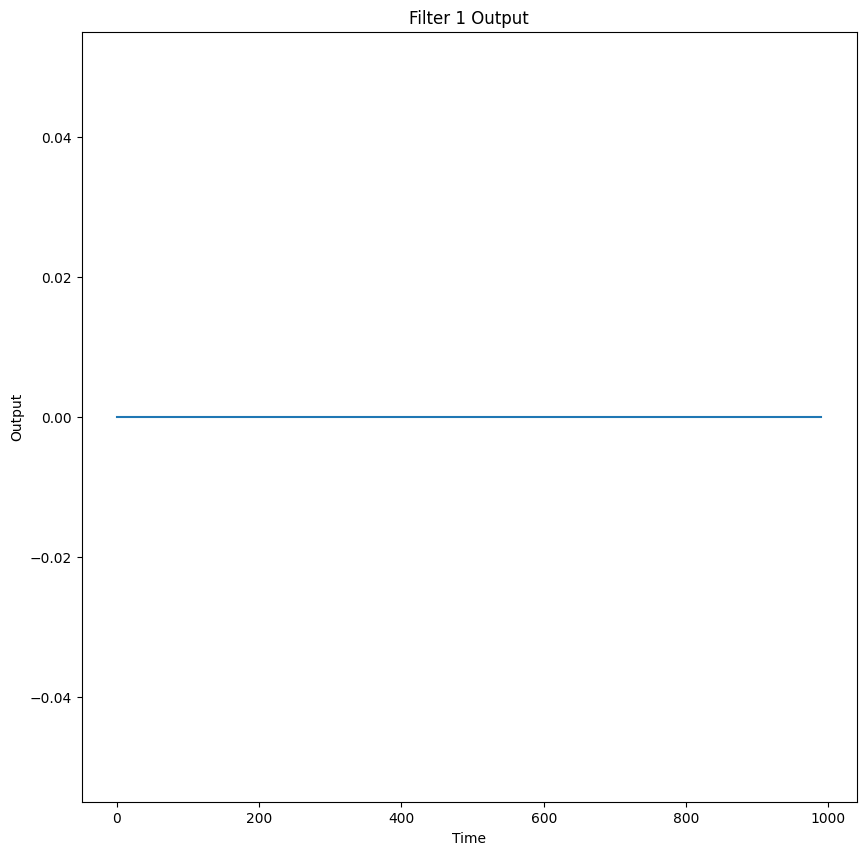

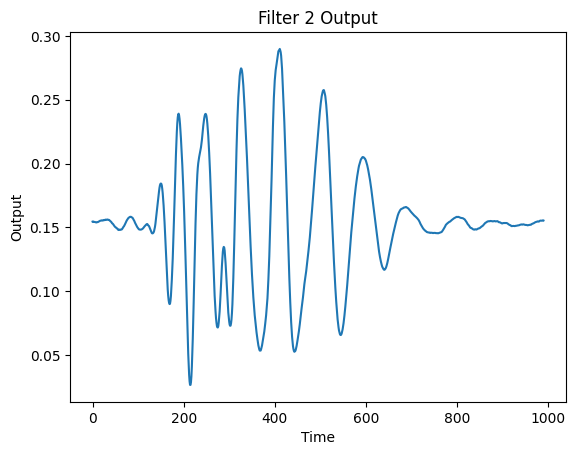

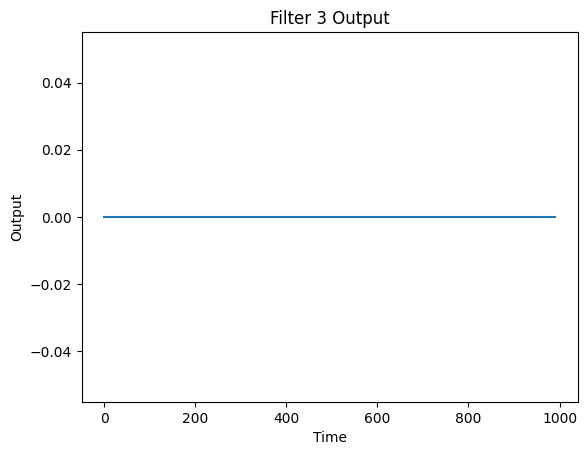

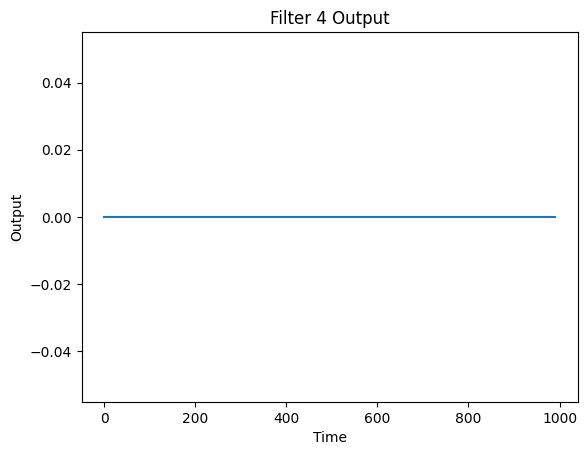

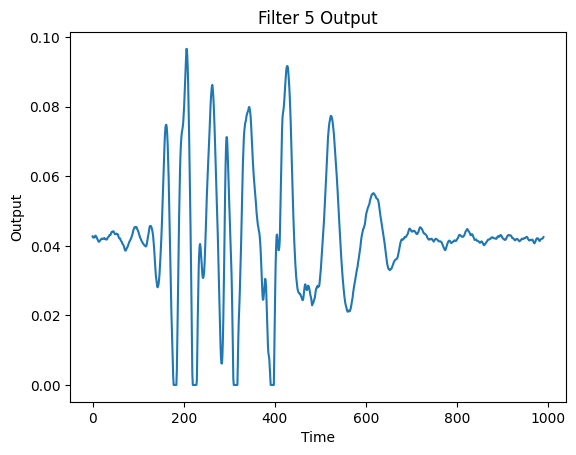

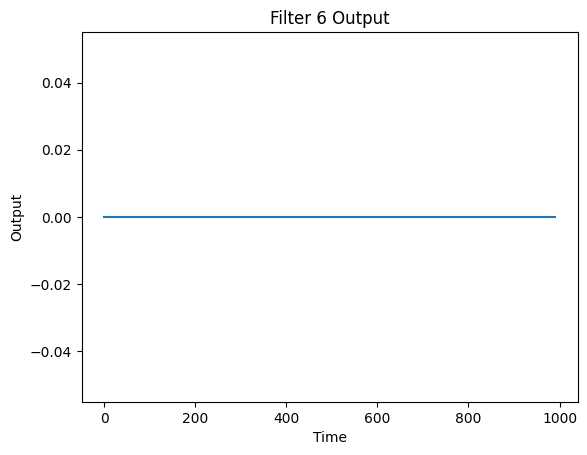

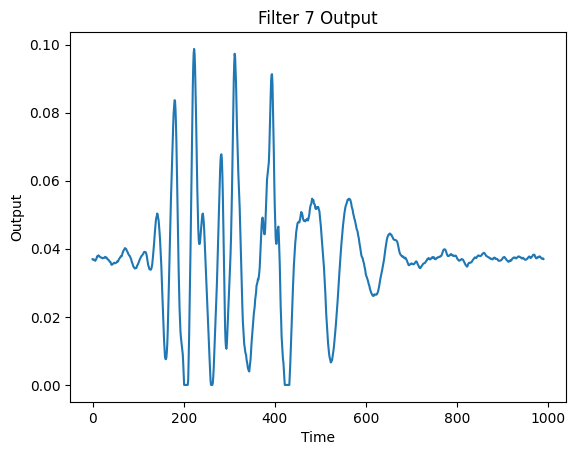

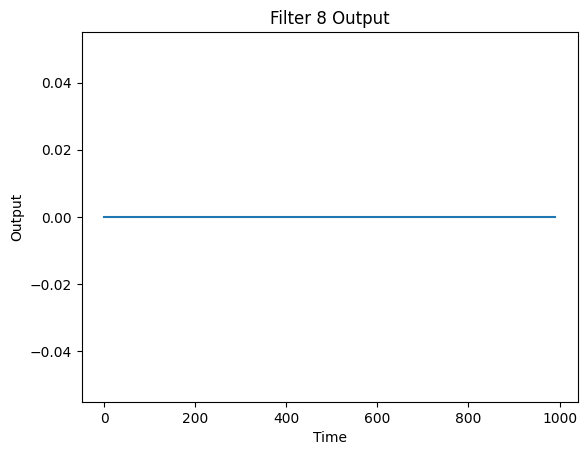

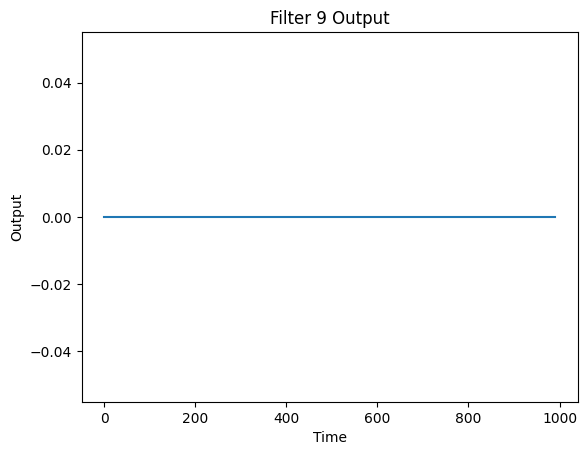

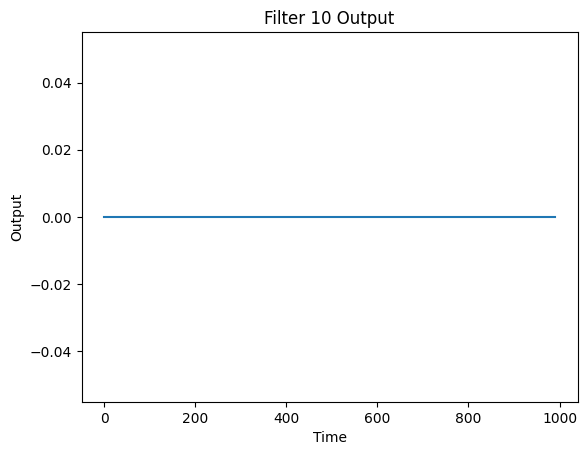

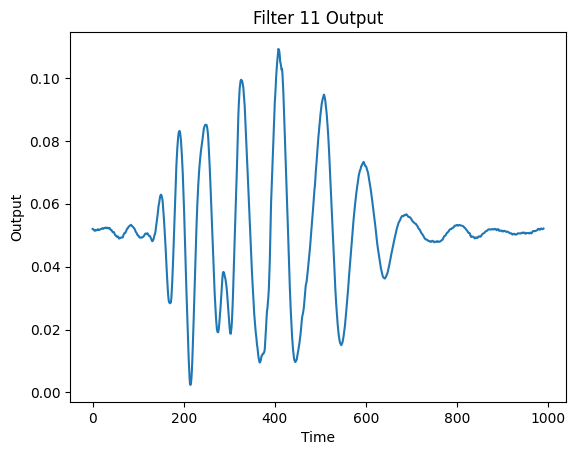

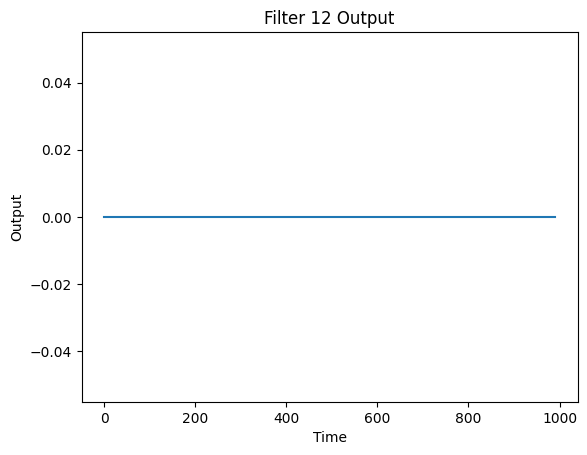

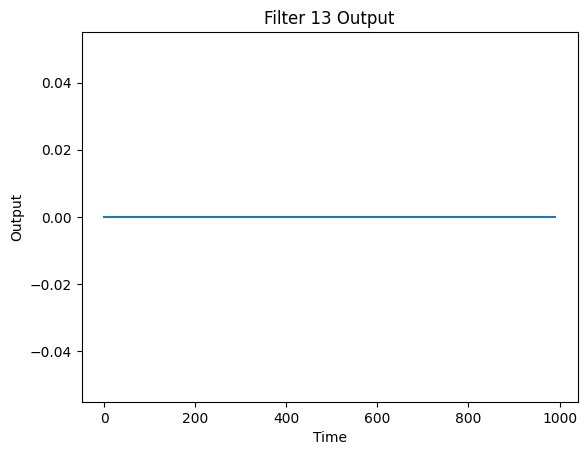

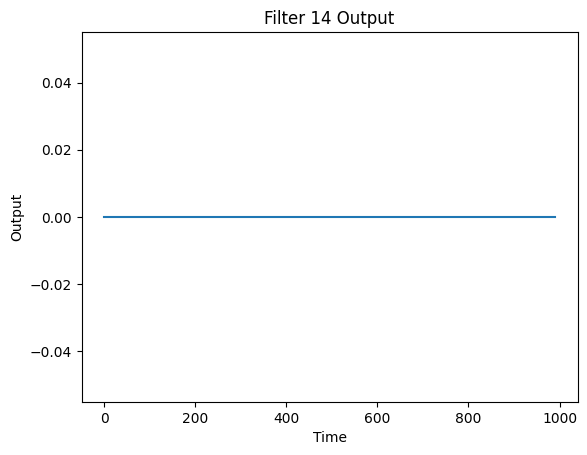

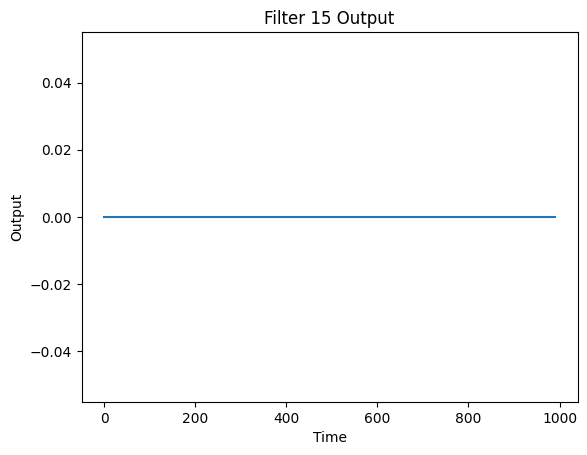

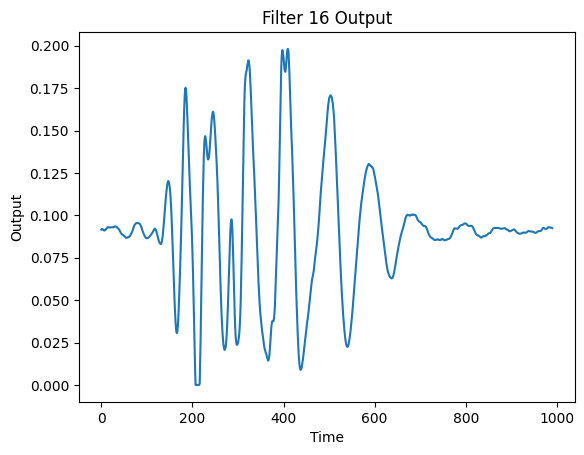

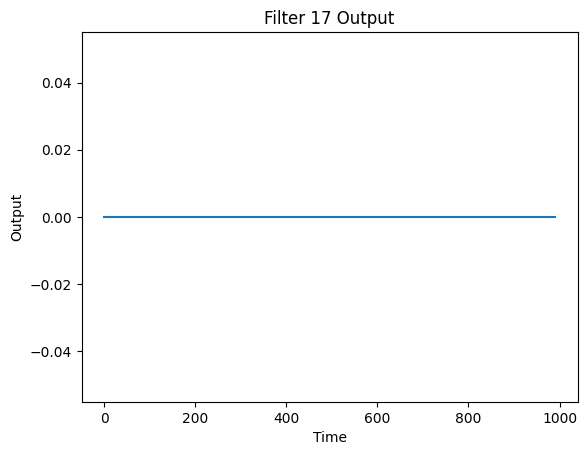

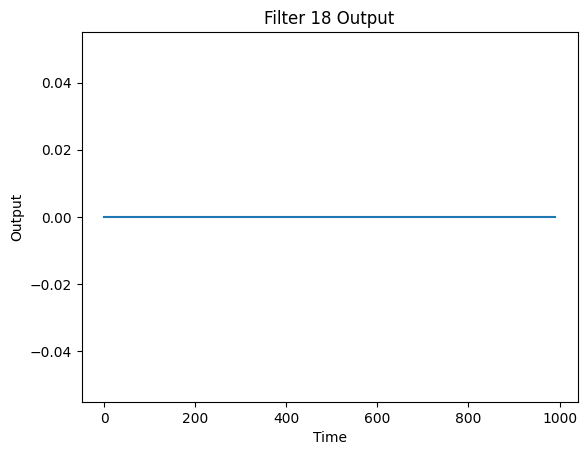

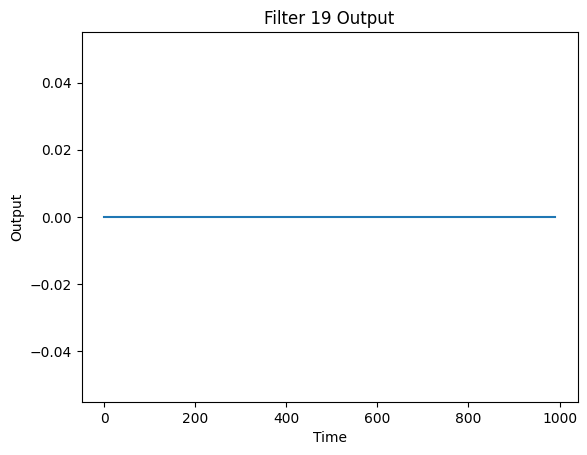

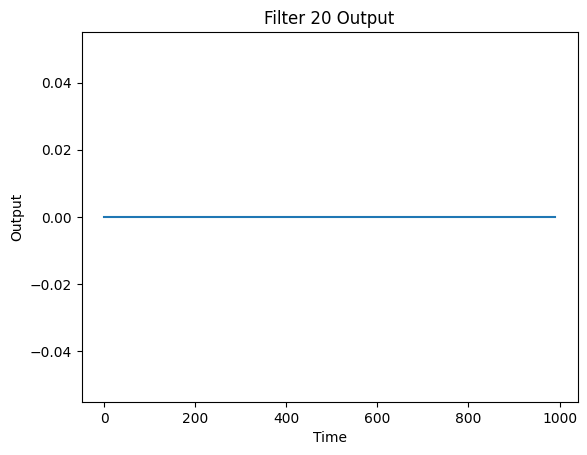

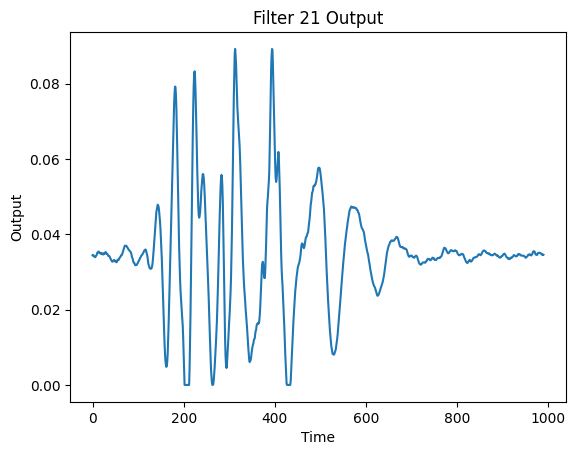

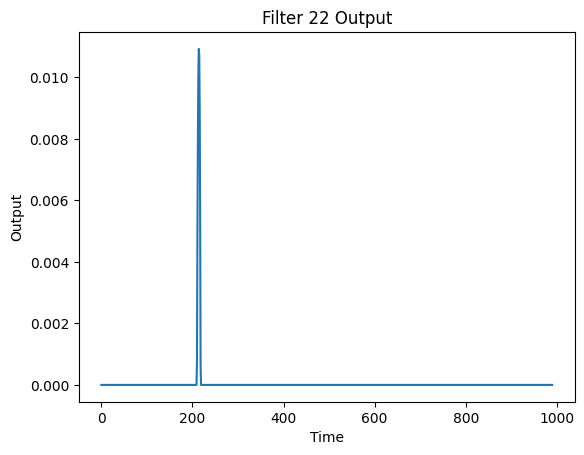

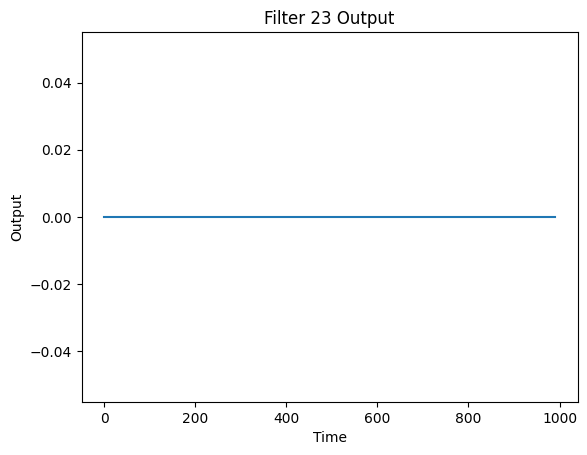

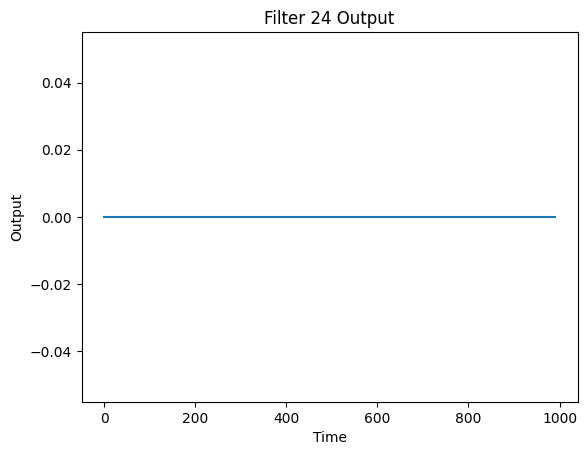

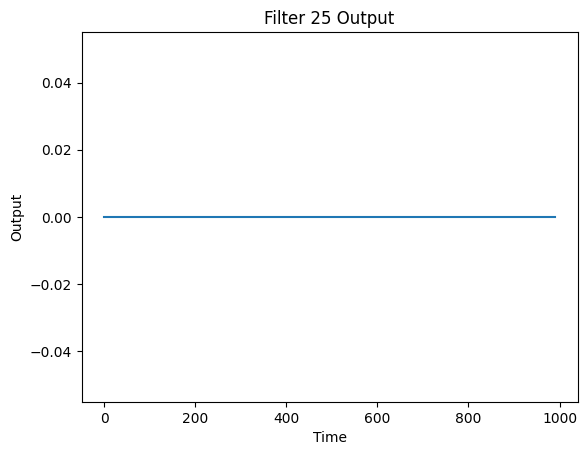

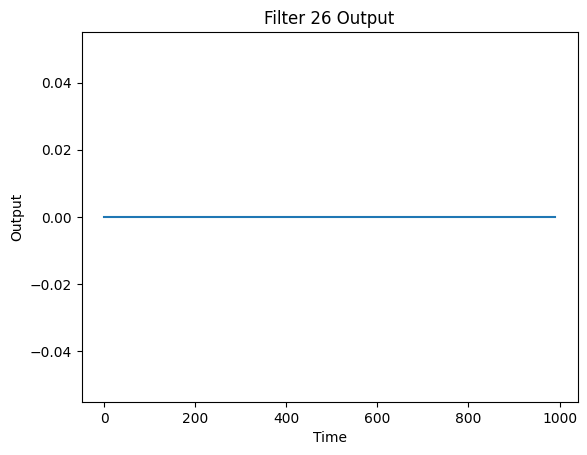

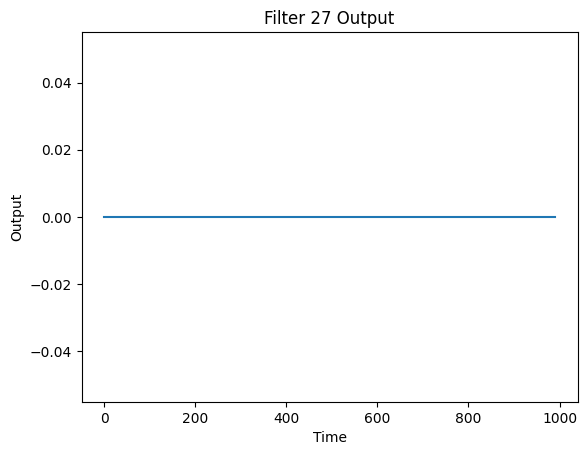

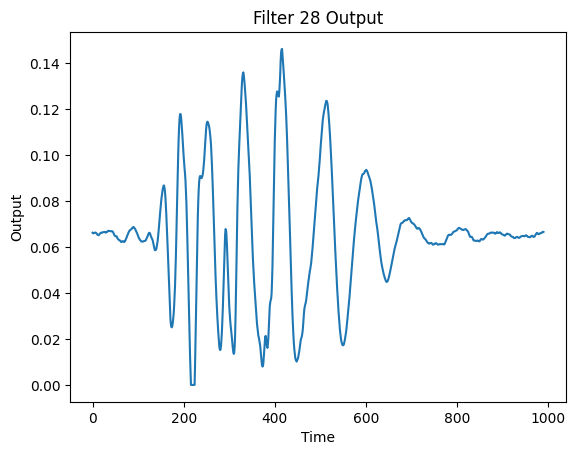

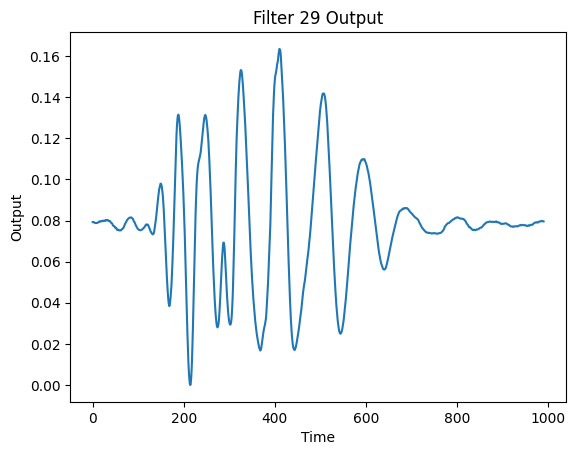

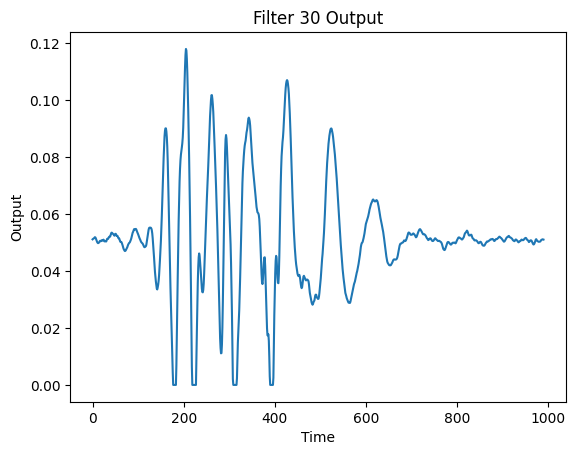

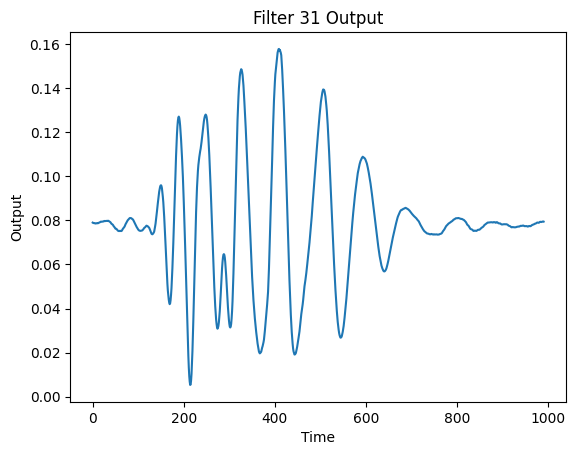

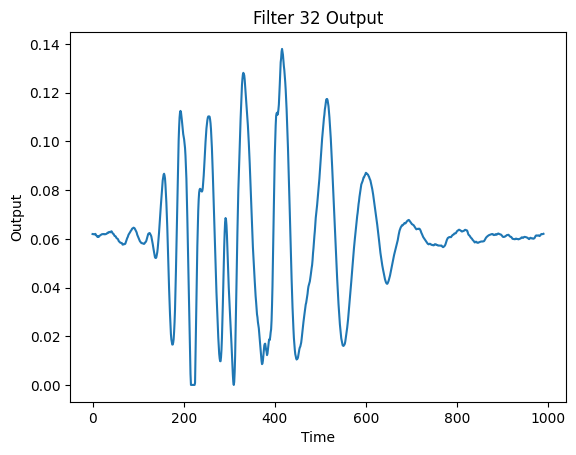

In [ ]:
import matplotlib.pyplot as plt
from keras.models import Model

visualization_model = Model(inputs=model.inputs, outputs=model.layers[0].output)

sample = x_train[0]

sample = sample.reshape((1,) + sample.shape)

feature_maps = visualization_model.predict(sample)

plt.figure(figsize=(10, 10))

for i in range(32):
    plt.plot(feature_maps[0, :, i])
    plt.title(f'Filter {i+1} Output')
    plt.xlabel('Time')
    plt.ylabel('Output')
    plt.show()

In [ ]:
model.save('heart_sound_classifier.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
